# 1. Giriş

Önceki yazılarda tartıştığımız zaman serisi modellerinin çoğu doğrusal zaman serisi modelleridir. Akademik ve uygulamalı araştırmaların ön saflarında yer almalarına rağmen, basit doğrusal zaman serisi modellerinin genellikle iktisadi ve finansal verilerin belirli yönlerini açıklanmadan bıraktığı bulunmuştur. İktisadi ve finansal sistemlerin hem yapısal hem de davranışsal değişikliklerden geçtiği bilindiğinden, ampirik verileri farklı zamanlarda açıklamak için farklı zaman serisi modellerinin gerekli olabileceğini varsaymak mantıklıdır. Bu yazıda, iktisadi ve finansal zaman serisi verilerinde doğrusal olmayan davranışı modellemede etkili olduğu tespit edilen bazı popüler doğrusal olmayan zaman serisi modelleri üzerinde duracağız.

Uygulamalar için, BIST-100 endeksi getirileri üzerine çalışacağız. Endeks verilerine `investpy` çerçevesi ile erişeceğiz:

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import investpy as inv
import datetime

bist100 = yf.Ticker('XU100.IS')
bist100_verisi = bist100.history(start="2005-01-01", end="2021-06-01")

Kapanış fiyatlarını düzenleyelim:

In [2]:
def adjust(row):
    
    if row.name < pd.to_datetime("2020-07-26"):
        return row['Close'] / 100
    else:
        return row['Close']
    
bist100_verisi['Close'] = bist100_verisi.apply(adjust, axis=1)

Şimdi de kapanış fiyatlarının grafiğini çizelim:

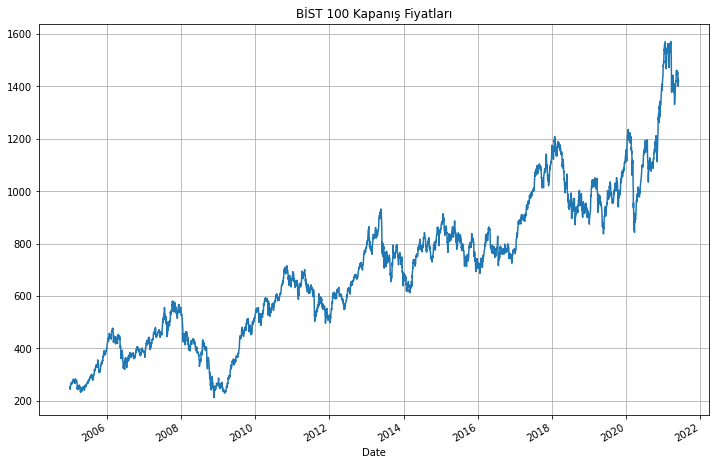

In [3]:
bist100_verisi.Close.plot(figsize=(12,8))
plt.grid()
plt.title("BİST 100 Kapanış Fiyatları");

Kapanış fiyatlarından günlük ve aylık getirileri hesaplayıp ayrı bir çerçeve oluşturalım:

In [4]:
bist_günlük_getiriler = pd.DataFrame()
bist_günlük_getiriler['getiriler'] = bist100_verisi['Close'].pct_change().dropna()

bist_aylık_getiriler = pd.DataFrame()
bist_aylık_getiriler['getiriler'] = bist100_verisi['Close'].resample('M').ffill().pct_change().dropna()

Günlük getirilerin grafiğini de çizelim:

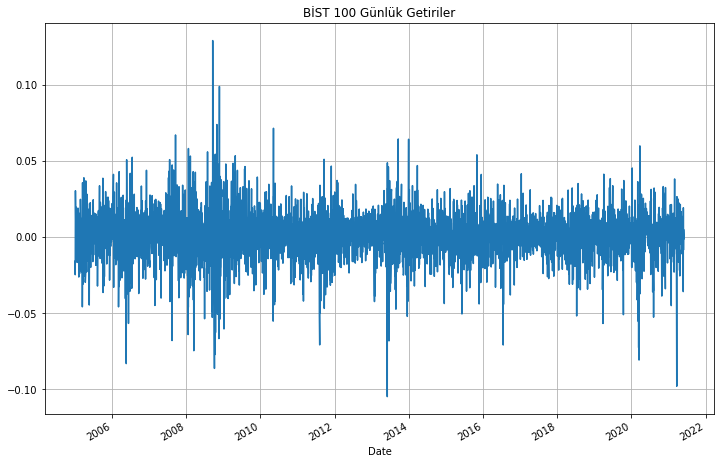

In [5]:
bist_günlük_getiriler.getiriler.plot(figsize=(12,8))
plt.grid()
plt.title("BİST 100 Günlük Getiriler");

Aylık getirilerin grafiğini de çizelim:

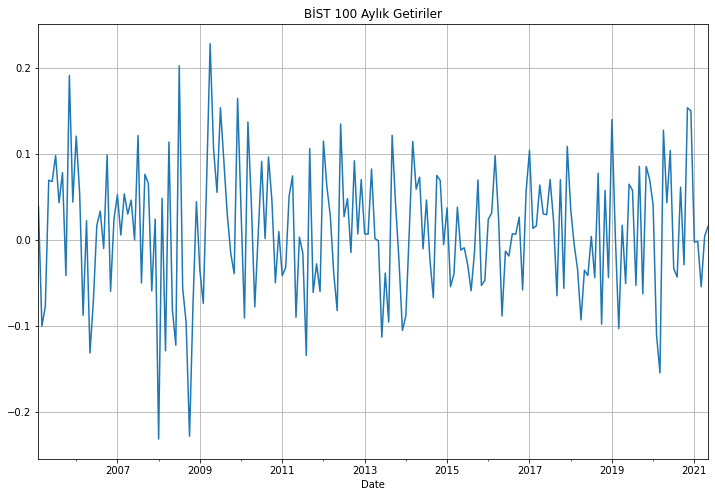

In [6]:
bist_aylık_getiriler.getiriler.plot(figsize=(12,8))
plt.grid()
plt.title("BİST 100 Aylık Getiriler");

# 2. Ortalamada Doğrusal Olmayan Modeller

Stokastik zaman serileri doğrusal fonksiyonda aşağıdaki şekilde gösterilebilir:

$$
\mathrm{X}_{\mathrm{t}}=\mu+\sum_{i=0}^{\infty} \varphi_{i} \alpha_{\mathrm{t}-\mathrm{i}}
$$

Burada, $\mu$ sabit terim, $\varphi_{0} = 1$ reel sayıları, $\alpha_{\mathrm{t}}$ ise bağımsız ve türdeş dağılımlı (iid) rassal değişkeni gösterir. Model fonksiyonel formda aşağıdaki şekilde gösterilebilir:

$$
X_{t}=f\left(a_{t}, a_{t-1}, \ldots\right)
$$

$f(.)$’nin fonksiyonel durumuna göre model doğrusal ya da doğrusal olmayan model olarak niteliklendirilebilmektedir. $f_{t-1}$, $\left(X_{t-1}, X_{t-2}, \ldots\right)$ ve $\left(\alpha_{t-1}, \alpha_{t-2}, \ldots\right)$ 'nin kombinsayonlarının toplamı olarak ifade edildiğinde $X_{t}$'nin koşullu ortalama ve varyansı aşağıdaki gibi gösterilebilir.

$$
\begin{aligned}
&\mu_{t}=E\left(X_{t} / F_{t-1}\right) \equiv g\left(F_{t-1}\right) \\
&\sigma^{2} t=\operatorname{Var}\left(X_{t} / F_{t-1}\right) \equiv h\left(F_{t-1}\right)
\end{aligned}
$$

Bu noktadan hareketle model; $\left.\mathrm{X_{t}}=\mathrm{g}\left(\mathrm{F}_{\mathrm{t}-1}\right)+\sqrt{h\left(F_{t-1}\right)\varepsilon_{\mathrm{t}}}\right)$ eğer doğrusal olmama $\mathrm{g}(.)$ 'den kaynaklanıyorsa **ortalamada doğrusal olmayan model**, eğer $\mathrm{h}(.)$ kaynaklanıyorsa **varyansta doğrusal olmayan model** olarak adlandirılır.

İktisadi ve finansal zaman serilerinde doğrusal olmayan davranışı modellemek için, dünyanın farklı durumlarının veya rejimlerinin varlığına izin vermek ve dinamiklerin farklı rejimlerde farklı olmasına izin vermek doğal görünmektedir.

## 2.1. Kendinden Uyarımlı Eşik Değerli Özbağlanım Modeli (Self-Exciting Threshold Autoregressive Model)

Doğrusal olmayan birçok durumu temsil edebilmesinden dolayı **eşik özbağlanım (threshold autoregressive - TAR)** modelleri, doğrusal olmayan biçimdeki modellerin en yaygın kullanılanıdır dşyebiliriz. TAR modelleri belli bir eşik değer belirleyerek, değişik rejimlerin finansal serilere uygulanmasını olanaklı kılmaktadır. Böylece her bir rejim kendi içinde doğrusal kalırken, serinin bütünü doğrusal olmayan özellikler sergileyebilmektedir. Aşağıda iki rejimli bir TAR modeli AR(1) parametreleri ile gösterilmiştir:

$$
y_{t}=\left\{\begin{array}{l}
\phi_{0,1}+\phi_{1,1} y_{t-1}+\varepsilon_{t} \text { eğer } y_{t} \leq c_{1} \\
\phi_{0,2}+\phi_{1,2} y_{t-1}+\varepsilon_{t} \text { eğer } y_{t}>c_{t}
\end{array}\right\}
$$

**Kendinden uyarımlı eşik değerli özbağlanım modelleri (self-exciting threshold autoregressive-SETAR)** ilk defa Tong ve Lim (1980) tarafından geliştirilmiştir. Aşağıda iki rejimli bir SETAR (1,1) modeli gösterilmiştir:

$$
y_{t}=\left\{\begin{array}{l}
\phi_{1,0}+\phi_{1,1} y_{t-1}+\sigma_{1} \varepsilon_{t} \text { eğer } y_{t-1} \leq r \\
\phi_{2,0}+\phi_{2,1} y_{t-1}+\sigma_{2} \varepsilon_{t} \text { eğer } y_{t-1}>r
\end{array}\right\}
$$

Geçiș değişkeni olarak adlandırılan $y_{t-1}$ bağımsız değişken $y_{t}$ ' nin 1 gecikmeli değeridir. İki doğrusal rejim arasındaki geçiş, bağımlı değişkenin 1 gecikmeli değerine bağlı olarak belirlenecektir. Eğer süreç eşik değerin altında seyrediyorsa düşük rejim, tersi durumda da yüksek rejim geçerlidir. Buna ek olarak her iki rejimin varyanslarının eşit olması beklenmemektedir.

## 2.2. Markov Geçiş Modelleri (Markow-Switcing Models)

Markov-geçiş modelleri sosyal bilimlerde yaygın olarak uygulanmaktadır. Markov-geçişli bağlanım modeli ilk olarak Quandt (1972) ve Goldfeld ve Quandt (1973) tarafından geliştirilmiştir. Yeni ufuklar açan bir makalede Hamilton (1989), AR süreçleri için Markov-geçişli bağlanımları genişletti ve öngörüler için doğrusal olmayan bir filtre sağladı. Hamilton (1993) ve Hamilton (1994, bölüm 22), Markov-geçişli bağlanım modellerine giriş için güzel bir başlangıç noktasıdır.

Markov-geçiş modelleri, sonlu bir gözlemlenmemiş durum (state) kümesi üzerinden geçiş yaptığına inanılan seriler için kullanılır ve sürecin her durumda farklı şekilde gelişmesine izin verir. Geçişler bir Markov sürecine göre gerçekleşir. Bir durumdan diğerine geçiş zamanı ve durum değişiklikleri arasındaki süre rassaldır. Örneğin, bu modeller, ekonomik büyümenin genişleme ve durgunluk arasında geçiş yaptığı zamanı ve her bir dönemin süresini yöneten süreci anlamak için kullanılabilir.

Aşağıdaki modellerde olduğu gibi, $t=1,2, \ldots, T$'nin iki durumla karakterize edildiği bir $y_{t}$ serisinin evrimini düşünelim:

* Durum 1: $y_{t}=\mu_{1}+\varepsilon_{t}$
* Durum 2: $y_{t}=\mu_{2}+\varepsilon_{t}$

burada $\mu_{1}$ ve $\mu_{2}$ sırasıyla durum 1 ve durum 2'deki sabit terimlerdir. $\varepsilon_{t}$, varyansı $\sigma^{2}$ olan bir beyaz gürültü hatasıdır. İki durum modeli, sabit terimde değişir. Anahtarların zamanlaması biliniyorsa, yukarıdaki model şu şekilde ifade edilebilir:

$$
y_{t}=s_{t} \mu_{1}+\left(1-s_{t}\right) \mu_{2}+\varepsilon_{t}
$$

burada $s_{t}$, süreç 1 durumundaysa 1'dir ve aksi takdirde 0'dır.

***Örnek: BİST 100 günlük getirileri için MS Modeli***

Bu model, rejim değişen varyanslılığı (varyansların değiştirilmesi) ve ortalama etkisi olmayan bir öngörü modelini gösterir. Model, Kim, Nelson, and Startz (1998) üç durumlu varyans geçiş modellerine dayanır. Model, formel olarak aşağıdaki gibi gösterilebilir:

$$
\begin{aligned}
&y_{t}=\varepsilon_{t} \\
&\varepsilon_{t} \sim N\left(0, \sigma_{S_{t}}^{2}\right)
\end{aligned}
$$

In [7]:
import statsmodels.api as sm

# modelin oluşturulması
bist_ms_model = sm.tsa.MarkovRegression(
    bist_günlük_getiriler, 
    k_regimes=3, 
    trend="n", 
    switching_variance=True
)

C:\Users\GTUSR0319\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [8]:
bist_ms_sonuç = bist_ms_model.fit()
print(bist_ms_sonuç.summary())

C:\Users\GTUSR0319\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                        Markov Switching Model Results                        
Dep. Variable:              getiriler   No. Observations:                 4116
Model:               MarkovRegression   Log Likelihood               11495.575
Date:                Sat, 29 Jan 2022   AIC                         -22973.150
Time:                        10:20:02   BIC                         -22916.246
Sample:                             0   HQIC                        -22953.008
                               - 4116                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.359e-05      8e-06     11.703      0.000    7.79e-05       0.000
                             Regime 1 parameters    

Rejimlerin her birinde bulunma olasılıklarını çizelim:

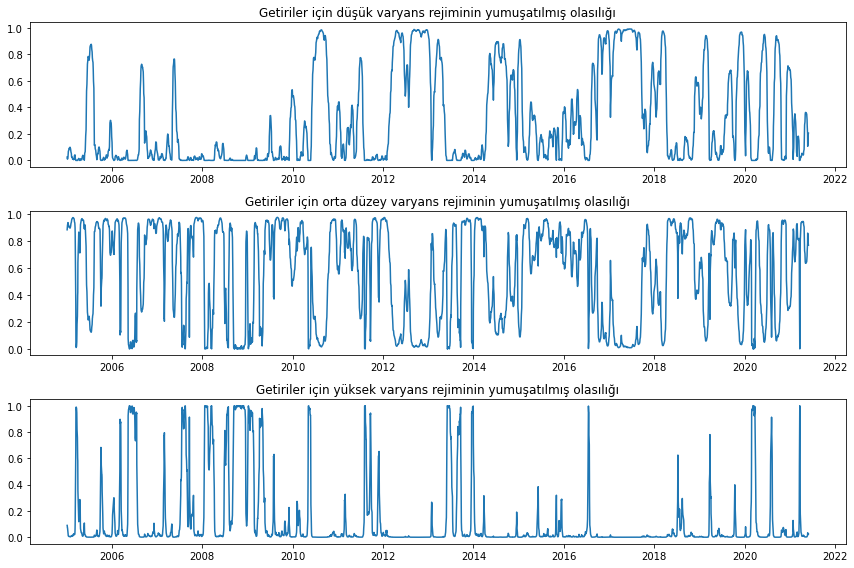

In [9]:
fig, axes = plt.subplots(3, figsize=(12, 8))

ax = axes[0]
ax.plot(bist_ms_sonuç.smoothed_marginal_probabilities[0])
ax.set(title="Getiriler için düşük varyans rejiminin yumuşatılmış olasılığı")

ax = axes[1]
ax.plot(bist_ms_sonuç.smoothed_marginal_probabilities[1])
ax.set(title="Getiriler için orta düzey varyans rejiminin yumuşatılmış olasılığı")

ax = axes[2]
ax.plot(bist_ms_sonuç.smoothed_marginal_probabilities[2])
ax.set(title="Getiriler için yüksek varyans rejiminin yumuşatılmış olasılığı")

fig.tight_layout()

# 3. Varyansta Doğrusal Olmayan Modeller

Hata terimlerinin diğer hata terimleri ile aralarında ilişki olması otokorelasyon olarak tanımlanır. Otokorelasyon genellikle zaman serilerinde karşılaşılan bir sorundur. Değişen varyans (heteroscedasticity) ise, anakütle hata terimi varyansının gözlemler itibariyle sabit olmamasıdır ve bir kesit verisi problemidir.

Engle(1982,1983) ve Cragg(1982) analizlerinde makro ekonomik verilerin zaman serisi modellerinde değişen varyans sorunu ile karşılaşıldığını ifade etmişlerdir.

$$
Y_{t+1}=e_{t+1} X_{t}
$$

modelini ele alalım. Böyle bir eşitlikte tüm $X_{t}$ değerleri birbirine eşit yani, $X_{t}=X_{t-1}=X_{t-2} \ldots \ldots$ ise, $Y_{t}$ serisi sabit varyansli olacaktır. Fakat $X_{t}$ değerleri eşit değil ise, $Y_{t+1}$ koşullu değişen varyansa sahip olacaktır.

$$
\operatorname{Var}\left(Y_{t+1} I X_{t}\right)=X_{t}^{2} \sigma^{2}
$$

$Y_{t+1}$ 'in koşullu varyansinın büyüklüğü $X_{t}$ değerlerine bağlidır ve $X_{t}$ değerleri ne kadar büyük olursa $Y_{t+1}$ 'in koşullu varyansı da o kadar büyük olacaktır. $X_{t}$ değerleri pozitif özilintili (autocorrelation) ise, $Y_{t}$ 'nin koşullu varyansı da pozitif özilintili olacaktır.

## 3.1. Özbağlanımlı Koşullu Değişen Varyans (Autoregressive Conditional Heteroscedasticity -ARCH) Modelleri

Engle (1982) tarafından önerilen orijinal ARCH modeli, bir bağlanım modelinin hatalarının varyansını, kareli bağlanım hatalarının gecikmeli değerlerinin doğrusal bir fonksiyonu olarak modellemiştir. $ARCH(m)$ modelini şu şekilde yazabiliriz:

$$
\begin{array}{rlr}
y_{t} & =\mathrm{x}_{t} \boldsymbol{\beta}+\epsilon_{t} & \text { (koşullu ortalama) } \\
\sigma_{t}^{2} & =\gamma_{0}+\gamma_{1} \epsilon_{t-1}^{2}+\gamma_{2} \epsilon_{t-2}^{2}+\cdots+\gamma_{m} \epsilon_{t-m}^{2} & \text { (koşullu varyans) }
\end{array}
$$

burada,

* $\epsilon_{t}^{2}$ karesel hatalar
* $\gamma_{i}$ ARCH parametresidir

***Örnek: BİST 100 Günlük Getirileri için ARCH Modeli***

ARCH modeli için, `arch` çerçevesini kullanacağız:

In [10]:
from arch import arch_model

# arch modeli
model = arch_model(bist_günlük_getiriler, vol = "ARCH", rescale = "FALSE")
model_uygulama = model.fit()

# model çıktısı
print(model_uygulama.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 3571290180.478702
Iteration:      2,   Func. Count:     17,   Neg. LLF: -8764.411021591446
Iteration:      3,   Func. Count:     25,   Neg. LLF: -11087.415778795152
Iteration:      4,   Func. Count:     31,   Neg. LLF: -9139.599896195536
Iteration:      5,   Func. Count:     39,   Neg. LLF: -11177.647965304683
Iteration:      6,   Func. Count:     43,   Neg. LLF: -11177.64796731694
Iteration:      7,   Func. Count:     46,   Neg. LLF: -11177.647967316942
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11177.64796731694
            Iterations: 7
            Function evaluations: 46
            Gradient evaluations: 7
                      Constant Mean - ARCH Model Results                      
Dep. Variable:              getiriler   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Lo

## 3.2. Genelleştirilmiş Özbağlanımlı Koşullu Değişen Varyans (Generalized Autoregressive Conditional Heteroscedasticity - GARCH) Modelleri

ARCH modeli, hem koşullu ortalama hem de koşullu varyans için bir spesifikasyona sahiptir ve varyans, önceden beklenmeyen yeniliklerin boyutunun bir fonksiyonudur - $\epsilon_{t}^{2}$. Bu model, bir GARCH modeli olan koşullu varyansın gecikmeli değerlerini içerecek şekilde Bollerslev (1986) tarafından genelleştirildi. $GARCH(m; k)$ modeli şu şekilde yazılabilir:

$$
\begin{aligned}
y_{t} &=\mathrm{x}_{t} \boldsymbol{\beta}+\epsilon_{t} \\
\sigma_{t}^{2} &=\gamma_{0}+\gamma_{1} \epsilon_{t-1}^{2}+\gamma_{2} \epsilon_{t-2}^{2}+\cdots+\gamma_{m} \epsilon_{t-m}^{2}+\delta_{1} \sigma_{t-1}^{2}+\delta_{2} \sigma_{t-2}^{2}+\cdots+\delta_{k} \sigma_{t-k}^{2}
\end{aligned}
$$

burada,

* $\gamma_{i}$ ARCH parametreleridir.
* $\delta_{i}$ GARCH  parametreleridir.

Engle (1982) öncü çalışmasında hata teriminin, $t$'nin bir Gaussyen (normal) dağılım izlediğini varsaymıştır: $\epsilon_{t} \sim N\left(0, \sigma_{t}^{2}\right)$. Bununla birlikte, Mandelbrot (1963) ve diğerlerinin belirttiği gibi, getirilerin dağılımı leptokurtik görünmektedir, yani aşırı getiriler, getiriler normal dağılmış olsaydı beklenenden daha sık görülür. Bu nedenle normal dağılımdan daha kalın kuyruklara sahip olabilecek, t-dağılımı gibi diğer dağılımları varsayılabilir.

***Örnek: BİST 100 Günlük Getirileri için GARCH Modeli***

BİST 100 günlük getirileri için GARCH modelini oluşturalım:

In [11]:
from arch.univariate import arch_model

model = arch_model(bist_günlük_getiriler)
model_uygulama = model.fit()
print(model_uygulama.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 9.269469729505241e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 650457030071.6444
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2503645.186052971
Iteration:      4,   Func. Count:     47,   Neg. LLF: 6.296270929381882e+16
Iteration:      5,   Func. Count:     59,   Neg. LLF: 954245006566.8329
Iteration:      6,   Func. Count:     73,   Neg. LLF: -11400.762323658557
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11400.76233816758
            Iterations: 10
            Function evaluations: 73
            Gradient evaluations: 6
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              getiriler   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                11400.8
Distribution:                  No

## 3.3.  Glosten-Jagannathan-Runkle GARCH Model (GJR-GARCH)

GARCH modeline bir dönem gecikmeli bir asimetrik şok faktörü eklendiğinde GJR-GARCH biçimine dönüştürülebilir:

$$
\sigma_{t}^{2}=\omega+\alpha \epsilon_{t-1}^{2}+\gamma \epsilon_{t-1}^{2} I_{\left[\epsilon_{t-1}<0\right]}+\beta \sigma_{t-1}^{2}
$$

burada $I$ argümanı doğru olduğunda 1 değerini alan bir gösterge işlevidir.

Log olabilirlik, asimetrik bir terimin eklenmesiyle önemli ölçüde iyileşir ve parametre tahmini oldukça anlamlı olur.

***Örnek: BİST 100 Günlük Getirileri için GJR-GARCH Modeli***

BİST 100 getirileri için GJR-GARCH modelini oluşturalım. Bunun için `o` parametresini 1 olarak ayarlayacağız:

In [12]:
model = arch_model(bist_günlük_getiriler, p=1, o=1, q=1)
model_uygulama = model.fit(update_freq=5, disp="off")
print(model_uygulama.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:              getiriler   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                11443.7
Distribution:                  Normal   AIC:                          -22877.4
Method:            Maximum Likelihood   BIC:                          -22845.8
                                        No. Observations:                 4116
Date:                Sat, Jan 29 2022   Df Residuals:                     4115
Time:                        10:20:26   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.1606e-04  2.239e-04      3.645  2.670e-04 [3.

## 3.4. Eşik ARCH (Threshold ARCH-TARCH) Modeli

TARCH modeli, oynaklığı (volatility) mutlak değerler kullnarak modeller. TARCH modelinde oynaklık süreci:

$$
\sigma_{t}=\omega+\alpha\left|\epsilon_{t-1}\right|+\gamma\left|\epsilon_{t-1}\right| I_{\left[\epsilon_{t-1}<0\right]}+\beta \sigma_{t-1}
$$

Daha genel olarak, başka $K$ kuvvetleri için:

$$
\sigma_{t}^{\kappa}=\omega+\alpha\left|\epsilon_{t-1}\right|^{\kappa}+\gamma\left|\epsilon_{t-1}\right|^{\kappa} I_{\left[\epsilon_{t-1}<0\right]}+\beta \sigma_{t-1}^{\kappa}
$$

burada koşullu varyans $\left(\sigma_{t}^{\kappa}\right)^{2 / \kappa}$ ile gösterilir.

***Örnek: BİST 100 Günlük Getirileri için TARCH Modeli***

BİST 100 getirileri için TARCH modelini oluşturalım. Bunun için `power` parametresini `1.0` olarak ayarlayacağız:

In [13]:
model = arch_model(bist_günlük_getiriler, p=1, o=1, q=1, power=1.0)
model_uygulama = model.fit(update_freq=5, disp="off")
print(model_uygulama.summary())

                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:              getiriler   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:                11462.4
Distribution:                  Normal   AIC:                          -22914.8
Method:            Maximum Likelihood   BIC:                          -22883.2
                                        No. Observations:                 4116
Date:                Sat, Jan 29 2022   Df Residuals:                     4115
Time:                        10:20:29   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.0746e-04  2.016e-04      4.005  6.198e-05 [4.

## 3.5. Üstel GARCH (Exponential GARCH-EGARCH) Modeli

EGARCH modelinde, koşullu varyans maruz kalınan şokun sadece büyüklüğüne değil, aynı zamanda işaretine bağlı olarak değişebilmektedir. Modelin oynaklık süreci:

$$
\ln \sigma_{t}^{2}=\omega+\sum_{i=1}^{p} \alpha_{i}\left(\left|e_{t-i}\right|-\sqrt{2 / \pi}\right)+\sum_{j=1}^{o} \gamma_{j} e_{t-j}+\sum_{k=1}^{q} \beta_{k} \ln \sigma_{t-k}^{2}
$$

burada, $e_{t}=\epsilon_{t} / \sigma_{t}$.

***Örnek: BİST 100 Günlük Getirileri için EGARCH Modeli***

BİST 100 getirileri için EGARCH modelini oluşturalım. Bunun için `vol` parametresini `EGARCH` olarak ayarlayacağız:

In [14]:
model = arch_model(bist_günlük_getiriler, p=1, q=1, vol='EGARCH')
model_uygulama = model.fit(update_freq=5, disp="off")
print(model_uygulama.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              getiriler   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                11409.6
Distribution:                  Normal   AIC:                          -22811.2
Method:            Maximum Likelihood   BIC:                          -22785.9
                                        No. Observations:                 4116
Date:                Sat, Jan 29 2022   Df Residuals:                     4115
Time:                        10:20:32   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.2417e-03  2.160e-04      5.748  9.033e-09 [8.

## 3.6. Student-t Hataları

Finansal getiriler genellikle kalın kuyruklu bir dağılım gösterir ve Student's t dağılımı bu özelliği yakalamak için basit bir yöntemdir.

***Örnek: BİST 100 Günlük Getirileri için T Dağılımlı GARCH Modeli***

BİST 100 getirileri için t dağılımlı GARCH modelini oluşturalım. Bunun için `dist` parametresini `StudentsT` olarak ayarlayacağız:

In [15]:
model = arch_model(bist_günlük_getiriler, dist="StudentsT")
model_uygulama = model.fit(update_freq=5, disp="off")
print(model_uygulama.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    getiriler   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6107.66
Distribution:      Standardized Student's t   AIC:                           12225.3
Method:                  Maximum Likelihood   BIC:                           12256.9
                                              No. Observations:                 4116
Date:                      Sat, Jan 29 2022   Df Residuals:                     4115
Time:                              10:20:34   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------